/usr/lib/python3/dist-packages/matplotlib/cbook/deprecation.py:106: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  warnings.warn(message, mplDeprecation, stacklevel=1)


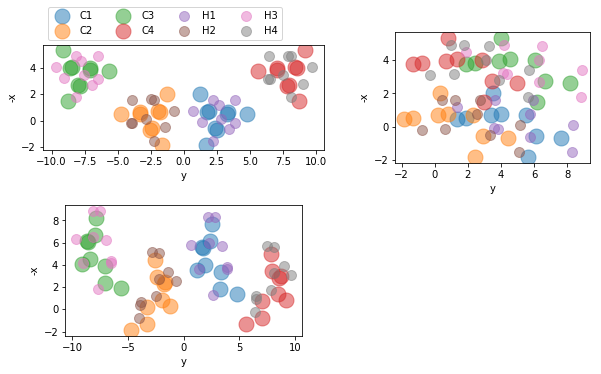

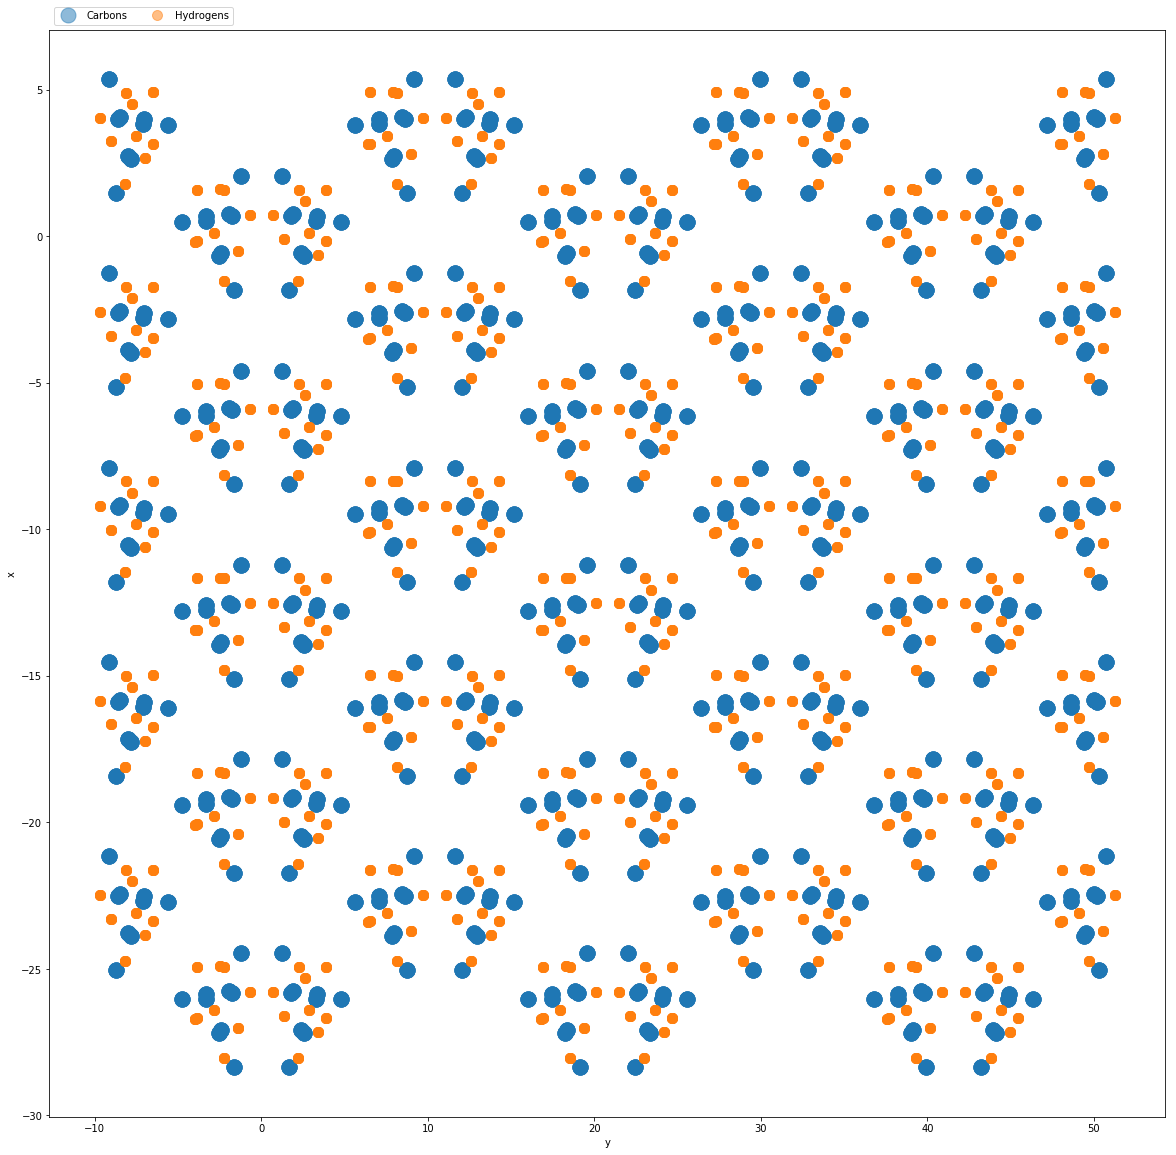

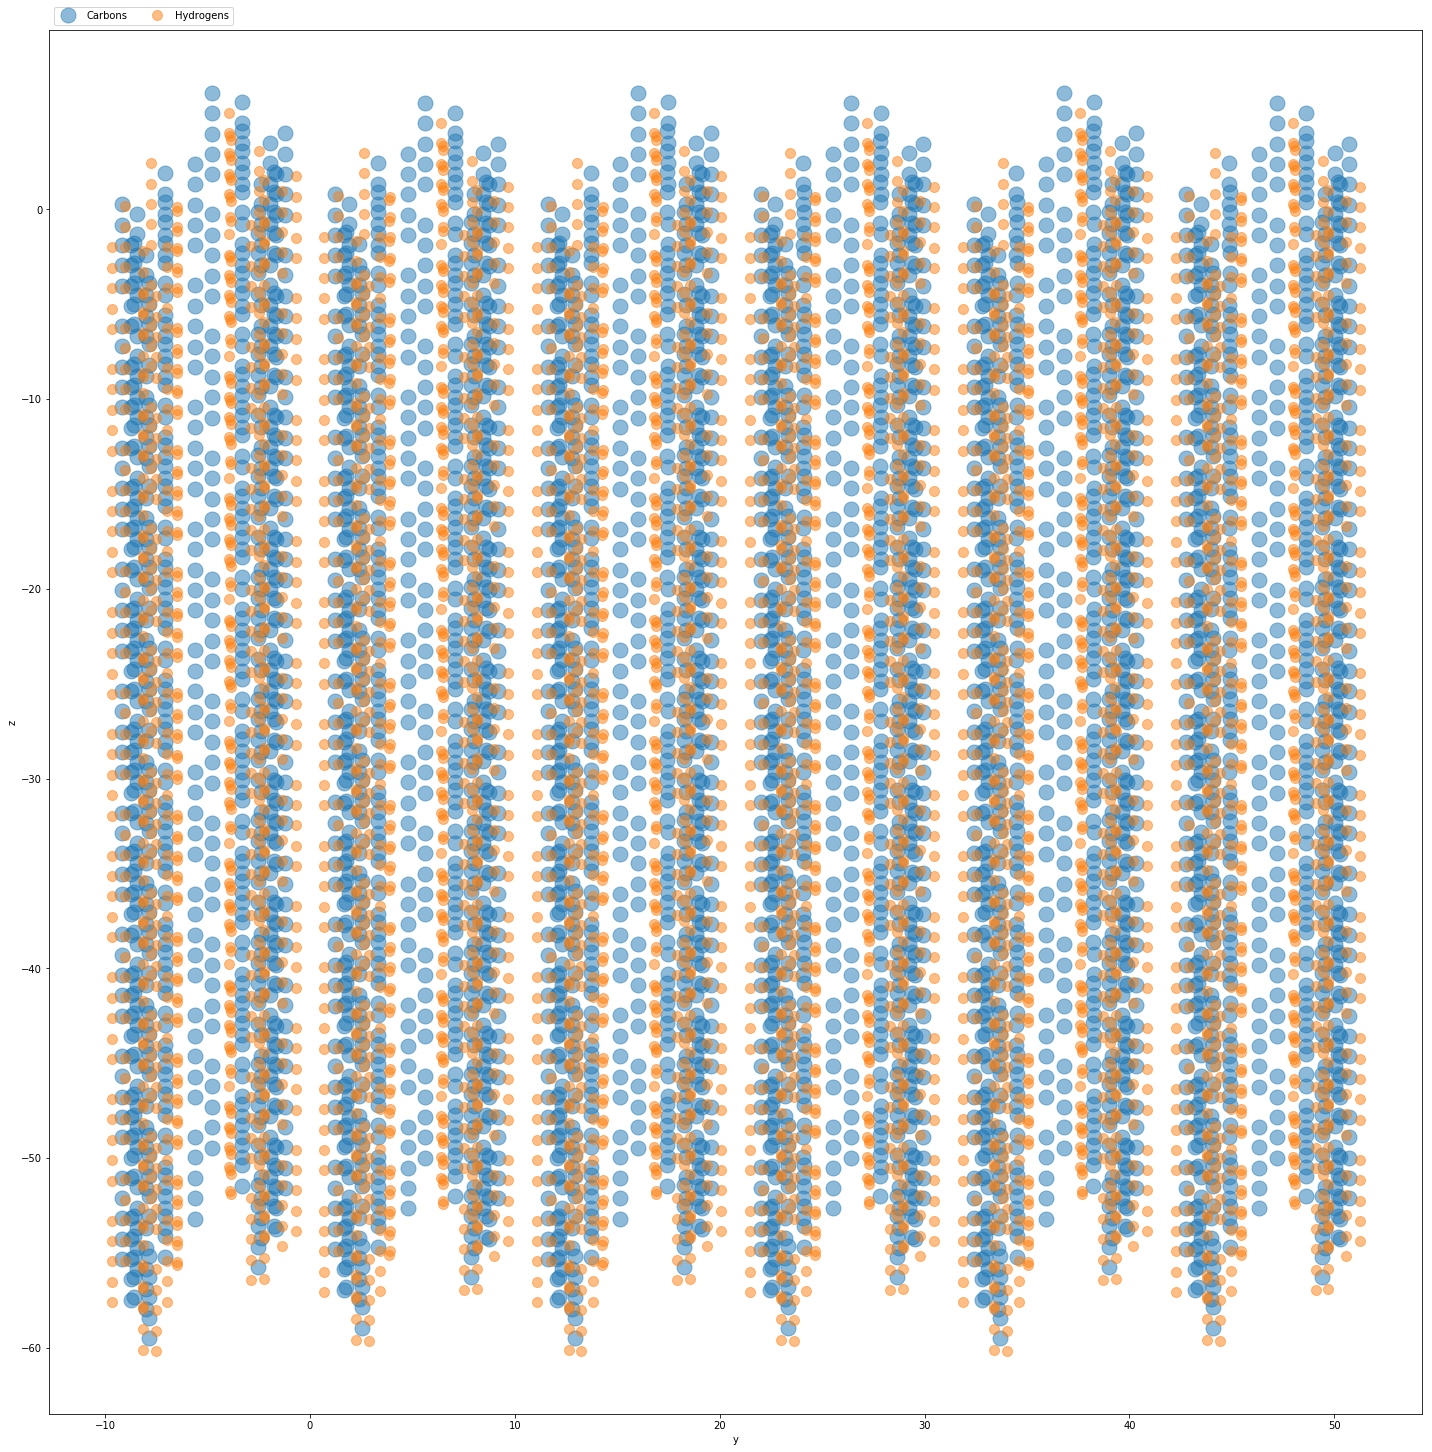

In [ ]:
import numpy
import math
from matplotlib import pyplot

''' Atomic fractional coordiantes x/a, y/b, and z/c
from (1988 Macromolecules Immiczi and Iannelil) 
Comments indicate bonding. '''

C1 = numpy.array([[-0.0727, 0.2291, 0.2004],  #C3 0: 1
                  [-0.0765, 0.1592, 0.2788],  #C1 1: 0 2
                  [-0.1021, 0.1602, 0.5098],  #C2 2: 1 4
                  [-0.3087, 0.0589, 0.4941],  #C3 3: 4
                  [-0.1146, 0.0928, 0.6057],  #C1 4: 2 3 5
                  [-0.1044, 0.0854, 0.8428],  #C2 5: 4 7
                  [ 0.2775, 0.0797, 0.9260],  #C3 6: 7
                  [ 0.0872, 0.1156, 0.9730],  #C1 7: 5 6 8
                  [ 0.1026, 0.1221, 1.2109]]) #C2 8: 7

''' Angle between c vector and x-axis. '''
beta = 99.5 * numpy.pi / 180.0

''' Columns of unit_cell are the a, b, and c cell vectors. '''
unit_cell = numpy.array([[6.63,  0.00, 6.50*numpy.cos(beta)],
                         [0.00, 20.78, 0.0],
                         [0.00,  0.00, 6.50*numpy.sin(beta)]])


def apply_space_group(C1):
    ''' Edited symmetry operations to make figure match - not checked '''
    C2, C3, C4 = C1.copy(), C1.copy(), C1.copy()

    C2[:,0] =  C2[:,0]
    C2[:,1] = -C2[:,1]
    C2[:,2] =  C2[:,2] - 0.5

    C3[:,0] =  C3[:,0] - 0.5
    C3[:,1] =  C3[:,1] - 0.5
    C3[:,2] =  C3[:,2] 

    C4[:,0] =  C3[:,0] 
    C4[:,1] = -C3[:,1] 
    C4[:,2] =  C2[:,2]    
    
    return C1, C2, C3, C4



def apply_hydrogens(C,i):
    ''' Construction of hydrogens from Theodorou (MD of aPP Melts) with 
    l_H=0.11 nm and theta_H=1.28 rad and c=+1 in C1 & C4 and c=-1 in C2 & C3'''   
    
    temp = numpy.zeros(3)
    H = numpy.zeros([9,3])
    l_H = 1.1
    theta_H = 1.28
    c = 1
    
    
    # Non-Methyl Hydrogens (Chiral and Gemini)
    # Chiral(Pendant) hydrogen
    # r_Hi = r_Ci+c*l_H*[((r_Ri)-(r_Ci-1))cross((r_Ri)-(r_Ci+1))/|((r_Ri)-(r_Ci-1))cross((r_Ri)-(r_Ci+1))|]
    
    def chiral_H_direction(Ci,Cj,Ck):      
        return unit_vector(numpy.cross(Ci-Cj, Ci-Ck))
    
    temp[0] = C[8,0]+1.07  # deducing along the unit cell c axis and transform it into orthonormal coordinates
    temp[1] = C[8,1]   
    temp[2] = C[8,2]-6.41
    H[0,:] = C[1,:] + c*l_H*chiral_H_direction(C[0,:],temp[:],C[2,:])
    H[3,:] = C[4,:] + c*l_H*chiral_H_direction(C[3,:],C[2,:],C[5,:])
    H[6,:] = C[7,:] + c*l_H*chiral_H_direction(C[6,:],C[5,:],C[8,:])
    
     
    # Gemini hydrogens 
    # b(i) = rc(i) - rc(i-1)/|rc(i)-rc(i-1)|
    b = [None]*6
        
    b[0] = unit_vector(C[2,:] - C[1,:])
    b[1] = unit_vector(C[4,:] - C[2,:])
    
    b[2] = unit_vector(C[5,:] - C[4,:])
    b[3] = unit_vector(C[7,:] - C[5,:])
    
    b[4] = unit_vector(C[8,:] - C[7,:])
    temp[0] = C[1,0]+1.07
    temp[1] = C[1,1]
    temp[2] = C[1,2]-6.41
    b[5] = unit_vector(temp[:] - C[8,:])


    # u(i) = (b(i) - b(i+1))/sqrt(2*(1-b(i).b(i+1))    
    u = [None]*3

    def bisector_vector(b1,b2):
        return (b1 - b2) / math.sqrt(2.0*(1.0 - numpy.dot(b1,b2)))
      
    # v(i) = (b(i) X b(i+1))/|b(i) X b(i+1)|
    v = [None]*3

    def plane_normal(b1,b2):
        return numpy.cross(b1,b2)/numpy.linalg.norm(numpy.cross(b1,b2))

    # rH(i) = rc(i) + lH*(sin(thetaH/2)*u(i) +- cos(thetaH/2)*v(i))
    def gemini_hydrogen(u,v,n):
        if n == 1:
            return (numpy.sin(theta_H/2)*u+numpy.cos(theta_H/2)*v)
        else:
            return (numpy.sin(theta_H/2)*u-numpy.cos(theta_H/2)*v)
    
    v[0] = plane_normal(b[0],b[1])
    u[0] = bisector_vector(b[0],b[1])
    H[1,:] = C[2,:]+l_H*gemini_hydrogen(u[0],v[0],1)
    H[2,:] = C[2,:]+l_H*gemini_hydrogen(u[0],v[0],2)

    v[1] = plane_normal(b[2],b[3])
    u[1] = bisector_vector(b[2],b[3])
    H[4,:] = C[5,:]+l_H*gemini_hydrogen(u[1],v[1],1)
    H[5,:] = C[5,:]+l_H*gemini_hydrogen(u[1],v[1],2)

    v[2] = plane_normal(b[4],b[5])
    u[2] = bisector_vector(b[4],b[5])
    H[7,:] = C[8,:]+l_H*gemini_hydrogen(u[2],v[2],1)
    H[8,:] = C[8,:]+l_H*gemini_hydrogen(u[2],v[2],2)  
    
    '''
    # Methyl Group Hydrogens 
    for i in range(0,9,3):
        H[9+i,0] = C[1+i,0] + 1.037
        H[9+i,1] = C[1+i,1] 
        H[9+i,2] = C[1+i,2] - 0.37
        H[10+i,0] = C[1+i,0] - 0.5185        
        H[10+i,1] = C[1+i,1] + 0.898
        H[10+i,2] = C[1+i,2] - 0.37
        H[11+i,0] = C[1+i,0] - 0.5185
        H[11+i,1] = C[1+i,1] - 0.898       
        H[11+i,2] = C[1+i,2] - 0.37
    '''
    
    return H
    


def plot_unit_cell(CC):
    
    C = numpy.vstack([numpy.dot(C, unit_cell) for C in apply_space_group(CC)])    
    H = numpy.zeros([36,3])
    
    for i in range(4):
        H[9*i:9*(i+1),:] = apply_hydrogens(C[9*i:9*(i+1),:],i) 
    
    lx, ly = unit_cell[0,0], unit_cell[1,1]
    
    figure = pyplot.figure(figsize=(9,5))
    aC = pyplot.subplot(221)
    aH = pyplot.subplot(221)
    
    aC.plot(C[:9,1],    -C[:9,0],    '.', ms=30, alpha=0.5, label='C1')
    aC.plot(C[9:18,1],  -C[9:18,0],  '.', ms=30, alpha=0.5, label='C2')
    aC.plot(C[18:27,1], -C[18:27,0], '.', ms=30, alpha=0.5, label='C3')
    aC.plot(C[27:36,1], -C[27:36,0], '.', ms=30, alpha=0.5, label='C4')
    aC.set_xlabel('y')
    aC.set_ylabel('-x')
    aC.set_aspect('equal')
    
    aH.plot(H[:9,1],    -H[:9,0],    '.', ms=20, alpha=0.5, label='H1')
    aH.plot(H[9:18,1],  -H[9:18,0],  '.', ms=20, alpha=0.5, label='H2')
    aH.plot(H[18:27,1], -H[18:27,0], '.', ms=20, alpha=0.5, label='H3')
    aH.plot(H[27:36,1], -H[27:36,0], '.', ms=20, alpha=0.5, label='H4')
    aH.set_xlabel('y')
    aH.set_ylabel('-x')
    aH.set_aspect('equal')
    
    pyplot.legend(ncol=4, bbox_to_anchor=(0,1), loc='lower left')
    aC = pyplot.subplot(222)
    aH = pyplot.subplot(222)
    
    aC.plot(C[:9,2],    -C[:9,0],    '.', ms=30, alpha=0.5, label='C1')
    aC.plot(C[9:18,2],  -C[9:18,0],  '.', ms=30, alpha=0.5, label='C2')
    aC.plot(C[18:27,2], -C[18:27,0], '.', ms=30, alpha=0.5, label='C3')
    aC.plot(C[27:36,2], -C[27:36,0], '.', ms=30, alpha=0.5, label='C4')
    aC.set_xlabel('z')
    aC.set_ylabel('-x')
    aC.set_aspect('equal')
    
    aH.plot(H[:9,2],    -H[:9,0],    '.', ms=20, alpha=0.5, label='H1')
    aH.plot(H[9:18,2],  -H[9:18,0],  '.', ms=20, alpha=0.5, label='H2')
    aH.plot(H[18:27,2], -H[18:27,0], '.', ms=20, alpha=0.5, label='H3')
    aH.plot(H[27:36,2], -H[27:36,0], '.', ms=20, alpha=0.5, label='H4')
    aH.set_xlabel('y')
    aH.set_ylabel('-x')
    aH.set_aspect('equal')

    aC = pyplot.subplot(223)
    aH = pyplot.subplot(223)

    aC.plot(C[:9,1],    C[:9,2],    '.', ms=30, alpha=0.5, label='C1')
    aC.plot(C[9:18,1],  C[9:18,2],  '.', ms=30, alpha=0.5, label='C2')
    aC.plot(C[18:27,1], C[18:27,2], '.', ms=30, alpha=0.5, label='C3')
    aC.plot(C[27:36,1], C[27:36,2], '.', ms=30, alpha=0.5, label='C4')
    aC.set_xlabel('y')
    aC.set_ylabel('z')
    aC.set_aspect('equal')
    
    aH.plot(H[:9,1],    H[:9,2],    '.', ms=20, alpha=0.5, label='H1')
    aH.plot(H[9:18,1],  H[9:18,2],  '.', ms=20, alpha=0.5, label='H2')
    aH.plot(H[18:27,1], H[18:27,2], '.', ms=20, alpha=0.5, label='H3')
    aH.plot(H[27:36,1], H[27:36,2], '.', ms=20, alpha=0.5, label='H4')
    aH.set_xlabel('y')
    aH.set_ylabel('-x')
    aH.set_aspect('equal')
    
    pyplot.tight_layout()
    
    return CC
    

def unit_vector(v):
    return v / numpy.linalg.norm(v)

        
def crystal(a,b,c):
    ''' Creating the initial crystalline system - a & b & c are the dimensions of the system '''   
           
    C = numpy.vstack([C for C in apply_space_group(C1)])    
    Carbons = numpy.zeros([a*b*c*36,3])    
    Hydrogens = numpy.zeros([a*b*c*36,3])
                
    for i in range(a):
        Carbons[(36*i):(36*(i+1)),0] = C[:,0] + float(i)
        Carbons[(36*i):(36*(i+1)),1] = C[:,1]
        Carbons[(36*i):(36*(i+1)),2] = C[:,2]   
    
    for j in range(1,b):
        Carbons[36*(a*j):36*(a*(j+1)),0] = Carbons[0:36*a,0]
        Carbons[36*(a*j):36*(a*(j+1)),1] = Carbons[0:36*a,1] + float(j)         
        Carbons[36*(a*j):36*(a*(j+1)),2] = Carbons[0:36*a,2] 
        
    for k in range(1,c):
        Carbons[36*(a*b*k):36*(a*b*(k+1)),0] = Carbons[0:36*a*b,0]
        Carbons[36*(a*b*k):36*(a*b*(k+1)),1] = Carbons[0:36*a*b,1]          
        Carbons[36*(a*b*k):36*(a*b*(k+1)),2] = Carbons[0:36*a*b,2] + float(k)                    
    
    Carbons = numpy.dot(Carbons, unit_cell)   
    
    # number of chains = a*b*c*4
    for i in range(a*b*c*4):        
        Hydrogens[9*i:9*(i+1),:] = apply_hydrogens(Carbons[9*i:9*(i+1),:],i)            
    
    
    
    return Carbons, Hydrogens



def plot_crystal(C, H):
    
    fig1 = pyplot.figure(figsize = (20,20))      
    aC1 = pyplot.plot(C[:,1], -C[:,0],'.', ms=30, alpha=0.5, label='Carbons')
    aH1 = pyplot.plot(H[:,1], -H[:,0],'.', ms=20, alpha=0.5, label='Hydrogens')
    pyplot.xlabel('y')
    pyplot.ylabel('x')   
    pyplot.legend(ncol=4, bbox_to_anchor=(0,1), loc='lower left')
    
    fig2 = pyplot.figure(figsize = (20,20))    
    aC2 = pyplot.plot(C[:,1], -C[:,2],'.', ms=30, alpha=0.5, label='Carbons')
    aH2 = pyplot.plot(H[:,1], -H[:,2],'.', ms=20, alpha=0.5, label='Hydrogens')
    pyplot.xlabel('y')
    pyplot.ylabel('z')    
    pyplot.legend(ncol=4, bbox_to_anchor=(0,1), loc='lower left')
    pyplot.tight_layout()

CC = plot_unit_cell(C1)
C, H = crystal(5,3,9)


plot_crystal(C, H)


In [ ]:
# Determine which carbn atoms are bonded to each other.
def carbon_bonds(C):
    for i in range(len((C))):
        s = '{}:'.format(i)
        for j in range(len(C)):
            d = numpy.linalg.norm(C[i,:]-C[j,:])
            if i != j and d < 1.6:
                s += ' {} '.format(j)
        print(s)
    
    
carbon_bonds(C)


# Determine which hydrogen is connected to what carbon
def hydrogen_bonds(C,H):    
    for i in range(len(C)):
        h1 = '{}:'.format(i)
        for j in range(len(H)):
            dist = numpy.linalg.norm(C[i,:]-H[j,:])
            if abs(dist - 1.1) < 0.1:
                h1 += '{} '.format(j)
        print(h1)

hydrogen_bonds(C,H)


0: 1 
1: 0  2 
2: 1  4 
3: 4 
4: 2  3  5 
5: 4  7 
6: 7 
7: 5  6  8 
8: 7  541 
9: 10 
10: 9  11 
11: 10  13 
12: 13 
13: 11  12  14 
14: 13  16 
15: 16 
16: 14  15  17 
17: 16  550 
18: 19 
19: 18  20 
20: 19  22 
21: 22 
22: 20  21  23 
23: 22  25 
24: 25 
25: 23  24  26 
26: 25  559 
27: 28 
28: 27  29 
29: 28  31 
30: 31 
31: 29  30  32 
32: 31  34 
33: 34 
34: 32  33  35 
35: 34  568 
36: 37 
37: 36  38 
38: 37  40 
39: 40 
40: 38  39  41 
41: 40  43 
42: 43 
43: 41  42  44 
44: 43  577 
45: 46 
46: 45  47 
47: 46  49 
48: 49 
49: 47  48  50 
50: 49  52 
51: 52 
52: 50  51  53 
53: 52  586 
54: 55 
55: 54  56 
56: 55  58 
57: 58 
58: 56  57  59 
59: 58  61 
60: 61 
61: 59  60  62 
62: 61  595 
63: 64 
64: 63  65 
65: 64  67 
66: 67 
67: 65  66  68 
68: 67  70 
69: 70 
70: 68  69  71 
71: 70  604 
72: 73 
73: 72  74 
74: 73  76 
75: 76 
76: 74  75  77 
77: 76  79 
78: 79 
79: 77  78  80 
80: 79  613 
81: 82 
82: 81  83 
83: 82  85 
84: 85 
85: 83  84  86 
86: 85  88 
87: 88 
88: 86

588: 589 
589: 587  588  590 
590: 589  592 
591: 592 
592: 590  591  593 
593: 592  1126 
594: 595 
595: 62  594  596 
596: 595  598 
597: 598 
598: 596  597  599 
599: 598  601 
600: 601 
601: 599  600  602 
602: 601  1135 
603: 604 
604: 71  603  605 
605: 604  607 
606: 607 
607: 605  606  608 
608: 607  610 
609: 610 
610: 608  609  611 
611: 610  1144 
612: 613 
613: 80  612  614 
614: 613  616 
615: 616 
616: 614  615  617 
617: 616  619 
618: 619 
619: 617  618  620 
620: 619  1153 
621: 622 
622: 89  621  623 
623: 622  625 
624: 625 
625: 623  624  626 
626: 625  628 
627: 628 
628: 626  627  629 
629: 628  1162 
630: 631 
631: 98  630  632 
632: 631  634 
633: 634 
634: 632  633  635 
635: 634  637 
636: 637 
637: 635  636  638 
638: 637  1171 
639: 640 
640: 107  639  641 
641: 640  643 
642: 643 
643: 641  642  644 
644: 643  646 
645: 646 
646: 644  645  647 
647: 646  1180 
648: 649 
649: 116  648  650 
650: 649  652 
651: 652 
652: 650  651  653 
653: 652  655 
654: 655

1114: 1112  1113  1115 
1115: 1114  1648 
1116: 1117 
1117: 584  1116  1118 
1118: 1117  1120 
1119: 1120 
1120: 1118  1119  1121 
1121: 1120  1123 
1122: 1123 
1123: 1121  1122  1124 
1124: 1123  1657 
1125: 1126 
1126: 593  1125  1127 
1127: 1126  1129 
1128: 1129 
1129: 1127  1128  1130 
1130: 1129  1132 
1131: 1132 
1132: 1130  1131  1133 
1133: 1132  1666 
1134: 1135 
1135: 602  1134  1136 
1136: 1135  1138 
1137: 1138 
1138: 1136  1137  1139 
1139: 1138  1141 
1140: 1141 
1141: 1139  1140  1142 
1142: 1141  1675 
1143: 1144 
1144: 611  1143  1145 
1145: 1144  1147 
1146: 1147 
1147: 1145  1146  1148 
1148: 1147  1150 
1149: 1150 
1150: 1148  1149  1151 
1151: 1150  1684 
1152: 1153 
1153: 620  1152  1154 
1154: 1153  1156 
1155: 1156 
1156: 1154  1155  1157 
1157: 1156  1159 
1158: 1159 
1159: 1157  1158  1160 
1160: 1159  1693 
1161: 1162 
1162: 629  1161  1163 
1163: 1162  1165 
1164: 1165 
1165: 1163  1164  1166 
1166: 1165  1168 
1167: 1168 
1168: 1166  1167  1169 
1169: 1168

1573: 1571  1572  1574 
1574: 1573  2107 
1575: 1576 
1576: 1043  1575  1577 
1577: 1576  1579 
1578: 1579 
1579: 1577  1578  1580 
1580: 1579  1582 
1581: 1582 
1582: 1580  1581  1583 
1583: 1582  2116 
1584: 1585 
1585: 1052  1584  1586 
1586: 1585  1588 
1587: 1588 
1588: 1586  1587  1589 
1589: 1588  1591 
1590: 1591 
1591: 1589  1590  1592 
1592: 1591  2125 
1593: 1594 
1594: 1061  1593  1595 
1595: 1594  1597 
1596: 1597 
1597: 1595  1596  1598 
1598: 1597  1600 
1599: 1600 
1600: 1598  1599  1601 
1601: 1600  2134 
1602: 1603 
1603: 1070  1602  1604 
1604: 1603  1606 
1605: 1606 
1606: 1604  1605  1607 
1607: 1606  1609 
1608: 1609 
1609: 1607  1608  1610 
1610: 1609  2143 
1611: 1612 
1612: 1079  1611  1613 
1613: 1612  1615 
1614: 1615 
1615: 1613  1614  1616 
1616: 1615  1618 
1617: 1618 
1618: 1616  1617  1619 
1619: 1618  2152 
1620: 1621 
1621: 1088  1620  1622 
1622: 1621  1624 
1623: 1624 
1624: 1622  1623  1625 
1625: 1624  1627 
1626: 1627 
1627: 1625  1626  1628 
1628

In [ ]:
# Dteremine the angle between the Carbons

def carbon_angles(C):        
    phi = [None]*4
    phi[0] = numpy.dot((C[2,:]-C[1,:]),(C[4,:]-C[2,:]))/(numpy.linalg.norm(C[2,:]-C[1,:])*numpy.linalg.norm(C[4,:]-C[2,:]))
    phi[1] = numpy.dot((C[4,:]-C[2,:]),(C[5,:]-C[4,:]))/(numpy.linalg.norm(C[4,:]-C[2,:])*numpy.linalg.norm(C[5,:]-C[4,:]))
    phi[2] = numpy.dot((C[5,:]-C[4,:]),(C[7,:]-C[5,:]))/(numpy.linalg.norm(C[5,:]-C[4,:])*numpy.linalg.norm(C[7,:]-C[5,:]))    
    phi[3] = numpy.dot((C[7,:]-C[5,:]),(C[8,:]-C[7,:]))/(numpy.linalg.norm(C[7,:]-C[5,:])*numpy.linalg.norm(C[8,:]-C[7,:]))
    print(phi,'\n')
    
    return phi

phi = numpy.zeros(int(len(C)/4))

'''
for i in range (len(C)):
    carbon_angles(C)
'''
